# Libraries

In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import math
import random
import glob
from pycocotools.coco import COCO
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

import albumentations as A
# import rasterio


import torch
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import torch.nn as nn
from torchsummary import summary


import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch.utils.metrics import IoU,Fscore,Precision,Recall,Accuracy
from segmentation_models_pytorch.utils.losses import BCEWithLogitsLoss
from segmentation_models_pytorch.utils.losses import JaccardLoss,DiceLoss



import numpy as np
from sklearn.metrics import precision_recall_curve
import torch
import segmentation_models_pytorch as smp
from sklearn.metrics import average_precision_score
import torch.nn.functional as F

# Function 

In [5]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize=(8, 8))
  for i , (name, image) in enumerate(images.item()):
    plt.subplot(1,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(" ".join(name.split("_")).title())
    plt.imshow(image)
  plt.show()


# Start to create Model


In [6]:
#Read training and testing chip lists =======================================
train = pd.read_csv("data/for_semantic_seg_mask/train_semantic_seg_mask.csv")
test = pd.read_csv("data/for_semantic_seg_mask/valid_semantic_seg_mask.csv")

# Define Variables ========================================
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'panel', 'roof']
# CLASSES = ['panel', 'roof']
no = 3
ACTIVATION = None
# DEVICE = 'cuda'
DEVICE = 'cpu'


#Check if GPU is available ===================================
# avail = torch.cuda.is_available()
# devCnt = torch.cuda.device_count()
# devName = torch.cuda.get_device_name(0)
# print("Available: " + str(avail) + ", Count: " + str(devCnt) + ", Name: " + str(devName))

# Prepare Data

In [7]:
class MultiClassSegDataset(Dataset):
  def __init__(self, df, classes= None, Transform = None, ):
    self.df = df
    self.classes = CLASSES
    self.transform = Transform

  def __getitem__(self, idx):

    image_name = self.df.iloc[idx,1]
    mask_name = self.df.iloc[idx, 2]

    image = cv2.imread(image_name)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)

    image = image.astype("uint8")
    # mask = mask[:,:,0]

    if(self.transform is not None):
      # transformed = self.transform(image = image, mask = mask)
      # image = transformed["image"]
      # mask = transformed["mask"]

      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask)

      image = image.permute(2,0,1)
      image = image.float()/255
      mask = mask.long().unsqueeze(0)


    else:
      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask) 

      image = image.permute(2,0,1)
      image = image.float()/255
      mask = mask.long().unsqueeze(0)

    return image, mask


  def __len__(self):
    return len(self.df)
    

In [8]:
# test_transform = A.Compose([
#     A.PadIfNeeded(min_height = 512, min_width = 512, border_mode = 4),
#     A.Resize(512,512),
# ])

# train_transform = A.Compose([
#         A.PadIfNeeded(min_height = 512, min_width = 512, border_mode = 4),
#         A.Resize(512,512),
# ])

train_transform = None
test_transform = None


trainDS = MultiClassSegDataset(train, classes = CLASSES, Transform = train_transform)
testDS = MultiClassSegDataset(test, classes = CLASSES, Transform = test_transform)



trainDL = torch.utils.data.DataLoader(trainDS , batch_size = 8, shuffle = True, sampler = None,
                                      batch_sampler = None,  num_workers = 0, collate_fn = None,
                                      pin_memory = False, drop_last = False, timeout = 0,
                                      worker_init_fn = None)

testDL = torch.utils.data.DataLoader(testDS , batch_size = 8, shuffle = True, sampler = None,
                                      batch_sampler = None,  num_workers = 0, collate_fn = None,
                                      pin_memory = False, drop_last = False, timeout = 0,
                                      worker_init_fn = None)

In [9]:
batch = next(iter(trainDL))
images, labels = batch
print(images.shape,  labels.shape, type(images), type(labels),images.dtype , labels.dtype)

torch.Size([8, 3, 640, 640]) torch.Size([8, 1, 640, 640]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64


In [10]:
testImg = images[3]
testMask = labels[3]

print(testImg.shape, testImg.dtype ,type(testImg), 
      "\n",
      testMask.shape, testMask.dtype,  type(labels),
      "\n",
      testImg.min(), testImg.max(), testMask.min(), testMask.max())

torch.Size([3, 640, 640]) torch.float32 <class 'torch.Tensor'> 
 torch.Size([1, 640, 640]) torch.int64 <class 'torch.Tensor'> 
 tensor(0.) tensor(1.) tensor(0) tensor(2)


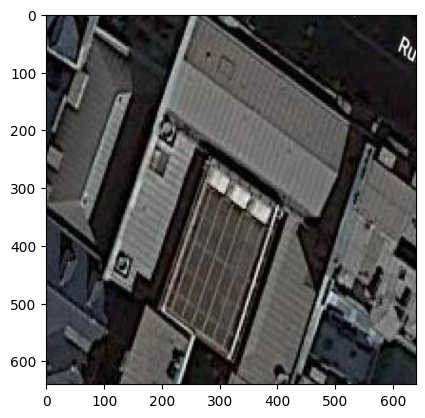

In [11]:
plt.imshow(testImg.permute(1,2,0))
plt.show()

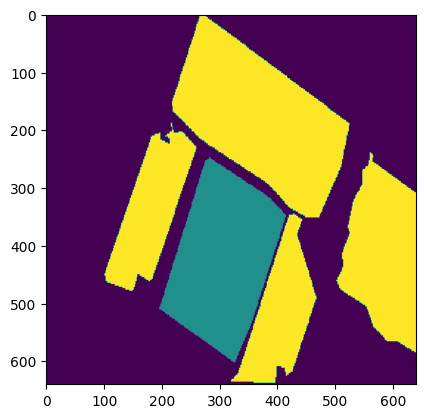

In [12]:
plt.imshow(testMask.permute(1,2,0))
plt.show()

# Setup model

In [13]:
# Initiate PSPNet Model ======================================
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=no,
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 282MB/s]


In [14]:
## Loss

# DiceLoss: The basic implementation of the Dice loss.
# BinaryDiceLoss: The Dice loss for binary segmentation tasks.
# DiceLossIgnoreIndex: The Dice loss that ignores a specified index during computation.
# BinaryFocalLoss: The Focal loss for binary segmentation tasks, with the Dice coefficient as the focal loss target.
# DiceCELoss: The combination of the Dice loss and the cross-entropy loss.
# DiceCELossIgnoreIndex: The combination of the Dice loss and the cross-entropy loss, ignoring a specified index during computation.
# FocalLoss: The Focal loss for multi-class segmentation tasks.
# FocalLossIgnoreIndex: The Focal loss for multi-class segmentation tasks, ignoring a specified index during computation.
# JaccardLoss: The Jaccard loss, which is also known as the Intersection over Union (IoU) loss.


## Metriec
# Accuracy: Computes the overall pixel accuracy of the predicted segmentation masks.
# IoU (Intersection over Union): Computes the IoU score for each class, which measures the overlap between the predicted and ground truth masks.
# Dice Coefficient: Computes the Dice coefficient for each class, which measures the similarity between the predicted and ground truth masks.
# F1 Score: Computes the F1 score for each class, which is the harmonic mean of precision and recall.
# Precision: Computes the precision score for each class, which measures the ratio of true positives to the sum of true positives and false positives.
# Recall: Computes the recall score for each class, which measures the ratio of true positives to the sum of true positives and false negatives.
# Mean Accuracy: Computes the average pixel accuracy across all classes.
# Mean IoU: Computes the average IoU score across all classes.
# Mean Dice Coefficient: Computes the average Dice coefficient across all classes.
# Class Accuracy: Computes the pixel accuracy for each individual class.


# IoU: Intersection over Union (Jaccard Index)
# Fscore: F1 Score
# Precision: Precision
# Recall: Recall
# Accuracy: Accuracy
# Specificity: Specificity
# DiceCoefficient: Dice Coefficient
# BCEWithLogitsLoss: Binary Cross-Entropy with Logits Loss
# JaccardLoss: Jaccard Loss
# DiceLoss: Dice Loss
# SoftBCEWithLogitsLoss: Soft Binary Cross-Entropy with Logits Loss
# SoftJaccardLoss: Soft Jaccard Loss

In [15]:
# loss = smp.losses.DiceLoss(mode="multiclass")
# loss.__name__ = "Dice_loss"

loss = smp.losses.JaccardLoss(mode="multiclass")
loss.__name__ = "JaccardLoss"

metrics = [smp.utils.metrics.IoU(), smp.utils.metrics.Precision(),smp.utils.metrics.Recall(), smp.utils.metrics.Accuracy()]

In [16]:
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)

In [17]:
train_epoch = smp.utils.train.TrainEpoch(
    model.to(DEVICE),
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = DEVICE,
    verbose = True
)

In [18]:
test_epoch = smp.utils.train.ValidEpoch(
    model.to(DEVICE),
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True
)

In [19]:
max_score = 0
num_epoch = 20

In [ ]:
for i in range(0, num_epoch):
  train_logs = train_epoch.run(trainDL)
  test_logs = test_epoch.run(testDL)
  torch.save(model, f"model/new_model_seg/best_model_fpn_with_{num_epoch}_epoch_2_class.pth")

train:  66%|██████▌   | 50/76 [18:14<09:30, 21.95s/it, JaccardLoss - 0.7254, iou_score - 0.3413, precision - 0.3279, recall - 1.137, accuracy - 1.564]

## check the result on test set

In [ ]:
# best_model = torch.load("/content/drive/MyDrive/Proactiveware/new_model/best_model_pspnet_with_20_epoch.pth",map_location=torch.device('cuDA'))
best_model = torch.load("model/new_model_seg/best_model_fpn_with_20_epoch.pth",map_location=torch.device('cpu'))

In [ ]:
# Evaluate model on validation set==============================

valid = pd.read_csv("data/for_semantic_seg_mask/test_semantic_seg_mask.csv")

validDS = MultiClassSegDataset(valid, classes = ['background', 'panel', 'roof'], Transform = test_transform)


validDL = torch.utils.data.DataLoader(validDS , batch_size = 8, shuffle = True, sampler = None,
                                      batch_sampler = None,  num_workers = 0, collate_fn = None,
                                      pin_memory = False, drop_last = False, timeout = 0,
                                      worker_init_fn = None)

In [ ]:
val_epoch = smp.utils.train.ValidEpoch(
    model = best_model,
    loss = loss,
    metrics = metrics,
    # optimizer = optimizer,
    device = DEVICE,
    # verbose = True
)
val_logs = val_epoch.run(validDL)
print(val_logs)

In [ ]:
#Visualize images, masks, and predictions=======================================
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

for i in range(1):
    n = np.random.choice(len(validDL))

    data_list = list(validDL)
    element = data_list[n]
    
    image_vis = data_list[n][0][0].permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')

    image, gt_mask = data_list[n][0][0], data_list[n][1][0]
    print("gt_mask",gt_mask.shape)
    print("image",image.shape)
    # print("gt_mask unique",np.unique(gt_mask.numpy()))


    gt_mask = gt_mask.squeeze()

    
    x_tensor = image.to(DEVICE).unsqueeze(0)

    pr_mask = best_model.predict(x_tensor)
    print("pr_mask",pr_mask[0].shape)


    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)    
    print("pr_probs", pr_probs.shape)          

    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    print("pr_mask", pr_mask.shape)          


    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    print("gt_mask",gt_mask.shape)
    print("pr_mask",pr_mask.shape)
        
    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )



# compare

In [ ]:
best_model = torch.load("model/new_model_seg/best_model_fpn_with_20_epoch.pth")

In [ ]:
test.head(2)

In [ ]:
true_labels = []
predicted_scores = []


for i in range(0,len(validDL)):
# for i in range(0,2):

    # n = np.random.choice(len(validDL))
    n = i
    data_list = list(validDL)
    element = data_list[n]
    
    image_vis = data_list[n][0][0].permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')

    image, gt_mask = data_list[n][0][0], data_list[n][1][0]
    
    gt_mask = gt_mask.squeeze()

    
    x_tensor = image.to(DEVICE).unsqueeze(0)

    pr_mask = best_model.predict(x_tensor)
    # predicted_scores.append(pr_mask)
    
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)              
    pr_mask_ = torch.argmax(pr_probs, dim=1).squeeze(1)

    pr_mask = (pr_mask_.squeeze().cpu().numpy().round())
    gt_mask_numpy = (gt_mask.squeeze().cpu().numpy().round())


    # # print("gt_mask",gt_mask.shape)
    # print("gt_mask_numpy",gt_mask_numpy.shape)

    # # print("pr_mask_",pr_mask_.shape)
    # print("pr_mask",pr_mask.shape)
    # # print(type(gt_mask), type(pr_mask_), type(pr_mask))


    true_labels.append(gt_mask_numpy)
    predicted_scores.append(pr_mask)


    # print("\n")

In [ ]:
print(len(true_labels), len(predicted_scores))
print(len(true_labels[0]), len(predicted_scores[0]))

In [ ]:
predicted_scores[0]

In [ ]:
true_labels[0]

In [ ]:
persicion_list = []
recall_list = []
for i in range(0, len(true_labels)):

  output_ = torch.from_numpy(predicted_scores[i])
  target_ = torch.from_numpy(true_labels[i])

  tp, fp, fn, tn = smp.metrics.get_stats(output_, target_, mode='multilabel', threshold=0.5)

  recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
  precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")

  persicion_list.append(precision)
  recall_list.append(recall)


In [ ]:
# # Concatenate true labels and predicted scores from all batches
true_labels_np = np.concatenate(true_labels)
predicted_scores_np = np.concatenate(predicted_scores)

In [ ]:
print(len(true_labels), len(predicted_scores))

In [ ]:
output = torch.from_numpy(predicted_scores_np)
target = torch.from_numpy(true_labels_np)

In [ ]:
tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multilabel', threshold=0.5)

In [ ]:
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
print("iou_score", iou_score)
# f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
# f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
print("accuracy",accuracy )
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
print("recall",recall )
precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
print("Precision",precision )

In [ ]:
import segmentation_models_pytorch as smp
from sklearn.metrics import auc
# Sort precision and recall values in descending order of recall
precision_values = sorted(persicion_list, reverse=True)
recall_values = sorted(recall_list, reverse=True)

# Compute AP using precision and recall values
ap = auc(recall_values, precision_values)

print("Average Precision (AP):", ap)